# <center>Logistic regression baseline</center>

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import graphviz
%matplotlib inline
sns.set()

We will load data from data.npz file.

In [2]:
# Load all numpy arrays except training images (in order to save memory).
def load_data():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        #X_train = npz_file['X_train']
        X_valid = npz_file['X_valid']
        X_test = npz_file['X_test']
        X_train_features = npz_file['X_train_features']
        X_valid_features = npz_file['X_valid_features']
        X_test_features = npz_file['X_test_features']
        y_train_1h = npz_file['y_train_1h']
        y_valid_1h = npz_file['y_valid_1h']
        y_test_1h = npz_file['y_test_1h']
        y_train = npz_file['y_train']
        y_valid = npz_file['y_valid']
        y_test = npz_file['y_test']
        class_indices = npz_file['class_indices']
        train_filenames = npz_file['train_filenames']
        valid_filenames = npz_file['valid_filenames']
        test_filenames = npz_file['test_filenames']
    return X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices

# load training images
def load_images():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        X_train = npz_file['X_train']
    return X_train

# merge two dictionaries
def merge_dict(x,y):
    d = x.copy()
    d.update(y)
    return d

# fit a model
def fit_model(model, grid, X_tr, y_tr, X_va, y_va, X_t, y_t):
    valid_scores = []
    train_scores = []
    params = []
    for params_dict in grid:
        #print (params_dict)
        params.append(params_dict)
        model.set_params(**params_dict)
        model.fit(X_tr, y_tr)
        train_scores.append(model.score(X_tr, y_tr))
        valid_scores.append(model.score(X_va, y_va))
    best_index = np.argmax(valid_scores)
    # refit model with best params
    model.set_params(**params[best_index])
    model.fit(X_tr, y_tr)
    test_score = model.score(X_t, y_t)
    return { 'best_params':params[best_index],
              'params':params,
             'train_scores':train_scores,
             'valid_scores':valid_scores,
             'test_score':test_score,
             'best_index':best_index,
              'best_valid_score':valid_scores[best_index],
              'best_model':model
            }

X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices = load_data()


## Logistic regression baseline
Another strong baseline to evaluate is logistic regression
- Evaluate the logistic regression baseline

In [3]:
lr_sm = Pipeline([
('scaler', StandardScaler()),
('lr_sm',LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000, random_state=0))
])
lr_ovr =  Pipeline([
('scaler', StandardScaler()),
('lr_sm',LogisticRegression(multi_class='ovr', solver='liblinear',max_iter=1000, random_state=0))
])

In [4]:
lr_sm.fit(X_train_features, y_train)
lr_sm.score(X_test_features, y_test)

0.94

In [5]:
lr_ovr.fit(X_train_features, y_train)
lr_ovr.score(X_test_features, y_test)

0.92

The Mutlinomial logistic regression gives best results than OVR(92%).

- Tune its regularization strength parameter with cross-validated grid-search

In [6]:
grid = {
        'lr__C' : np.logspace(-4, 4, 9)
       }
lr = Pipeline([
                ('scaler', StandardScaler()),
                ('lr',LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=0))
              ])
grid_cv = GridSearchCV(lr,param_grid=grid,cv=5,return_train_score=True, iid=True)
grid_cv.fit(X_train_features, y_train)
print('Test score :', grid_cv.score(X_test_features, y_test))

Test score : 0.94



The cross-validation results are the following :

In [7]:
cv_results = pd.DataFrame(grid_cv.cv_results_)[['param_lr__C',
                                           'mean_test_score', 'std_test_score', 'mean_train_score',
                                           'std_train_score']]
cv_results

,param_lr__C,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.0001,0.920714,0.011606,0.939643,0.002301
1,0.001,0.962857,0.013665,0.986071,0.001071
2,0.01,0.977857,0.003499,1.000000,0.000000
3,0.1,0.982857,0.003499,1.000000,0.000000
4,1,0.983571,0.002857,1.000000,0.000000
5,10,0.983571,0.002857,1.000000,0.000000
6,100,0.985000,0.002673,1.000000,0.000000
7,1000,0.983571,0.001750,1.000000,0.000000
8,10000,0.982857,0.002673,1.000000,0.000000


- Pick ten images and compute the probability for each class using the predict_proba() function of your estimator. Plot
the results for each image and comment your findings. For example, you can plot the ten images in subplots and
collect the probabilities in a DataFrame.

We have selected some image ids from all categories :

In [8]:
image_ids = [0,4,6,14,16,24,31,33,37,45]

let's display them

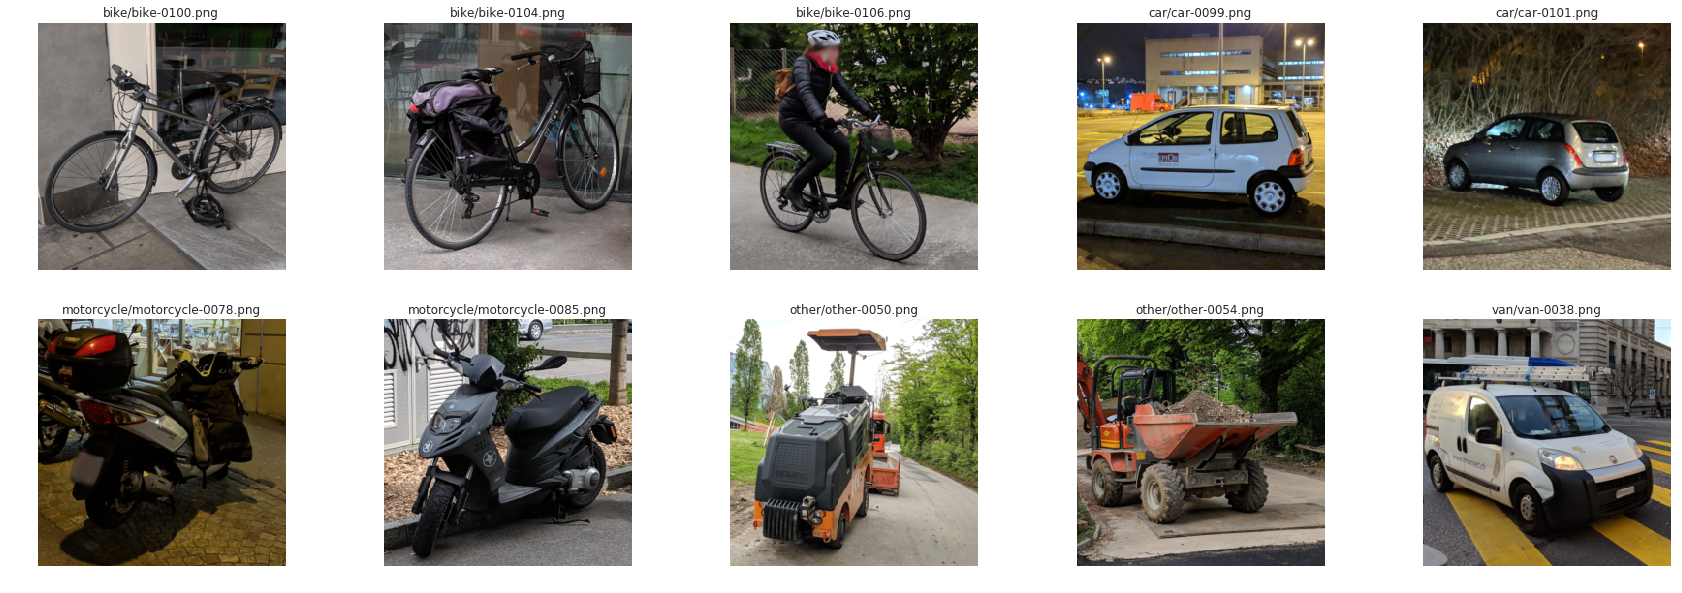

In [9]:
def show_images(di, images, lines = 1, cols=1, figsize=(30,10),titles=None):
    n = len(images)
    fig = plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        a = fig.add_subplot(lines, cols, i + 1)
        pil_im = Image.open(di+image,'r')
        plt.imshow(pil_im)
        if type(titles)==type(None):
            titles_=images
        else:
            titles_=titles
        a.set_title(f'{titles_[i]}')
        a.axis('off')
    fig.set_size_inches(figsize)
    plt.show()
show_images('data/test/',test_filenames[image_ids],2,5)

The following dataframe will display the probabilities for each image

In [10]:
pd.options.display.float_format = '{:,.5f}'.format
df = pd.DataFrame(grid_cv.predict_proba(X_test_features[image_ids]),columns= class_indices)
df['class'] = pd.Series(test_filenames[image_ids]).apply(lambda x:x.split('/')[0])
df['image_file'] = test_filenames[image_ids]
df

,bike,car,motorcycle,other,truck,van,class,image_file
0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,bike,bike/bike-0100.png
1,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,bike,bike/bike-0104.png
2,0.99981,0.00000,0.00019,0.00000,0.00000,0.00000,bike,bike/bike-0106.png
3,0.00000,0.99983,0.00000,0.00000,0.00000,0.00017,car,car/car-0099.png
4,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,car,car/car-0101.png
5,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,motorcycle,motorcycle/motorcycle-0078.png
6,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,motorcycle,motorcycle/motorcycle-0085.png
7,0.00000,0.00000,0.00000,0.04914,0.95079,0.00007,other,other/other-0050.png
8,0.00000,0.00000,0.00000,0.99239,0.00761,0.00000,other,other/other-0054.png
9,0.00000,0.00000,0.00000,0.00000,0.00012,0.99988,van,van/van-0038.png



We can also display probabilities and images together :

In [11]:
from IPython.display import Image, HTML
def path_to_image_html(path):
    return '<img src=data/test/'+ path + ' />'
df['image'] = test_filenames[image_ids]
HTML(df.to_html(escape=False ,formatters=dict(image=path_to_image_html)))

,bike,car,motorcycle,other,truck,van,class,image_file,image
0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,bike,bike/bike-0100.png,
1,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,bike,bike/bike-0104.png,
2,0.99981,0.00000,0.00019,0.00000,0.00000,0.00000,bike,bike/bike-0106.png,
3,0.00000,0.99983,0.00000,0.00000,0.00000,0.00017,car,car/car-0099.png,
4,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,car,car/car-0101.png,
5,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,motorcycle,motorcycle/motorcycle-0078.png,<img src=data/test/motorcycle/motorcycle-0078....
6,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,motorcycle,motorcycle/motorcycle-0085.png,<img src=data/test/motorcycle/motorcycle-0085....
7,0.00000,0.00000,0.00000,0.04914,0.95079,0.00007,other,other/other-0050.png,
8,0.00000,0.00000,0.00000,0.99239,0.00761,0.00000,other,other/other-0054.png,
9,0.00000,0.00000,0.00000,0.00000,0.00012,0.99988,van,van/van-0038.png,


- Finally, vary the regularization strength of your estimator. What is the effect on the probabilities? Write your
observations in a markdown cell.

We will fit our model for each C parameter value, and calculte probabilities for our selected images

In [12]:
grid = ParameterGrid({
        'lr__C' : np.logspace(-4, 4, 9)
       })
lr = Pipeline([
                ('scaler', StandardScaler()),
                ('lr',LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=0))
              ])

dfs=[]
for params in grid:
    lr.set_params(**params)
    lr.fit(X_train_features,y_train)
    df = pd.DataFrame(lr.predict_proba(X_test_features[image_ids]),columns= class_indices)
    df['param_C']=params['lr__C']
    df['class'] = pd.Series(test_filenames[image_ids]).apply(lambda x:x.split('/')[0])
    df['image_file'] = test_filenames[image_ids]
    dfs.append(df)

The probabilities ordered by image and C are displayed bellow :

In [13]:
pd.options.display.float_format = '{:,.4f}'.format
def change_color(r):
    #print(r)
    if r['image_id']%2 == 0:
        return ['background-color: lightgray']*10
    else:
        return ['background-color: gray']*10
df2 = pd.concat(dfs).sort_values(['image_file','param_C']).reset_index().rename(columns={'index':'image_id'})
df2[['image_id','image_file','class','param_C','bike', 'car', 'motorcycle', 'other', 'truck', 'van']].style.apply(change_color, axis=1)

,image_id,image_file,class,param_C,bike,car,motorcycle,other,truck,van
0,0,bike/bike-0100.png,bike,0.0001,0.963426,0.00714172,0.0107635,0.00834946,0.00558416,0.00473559
1,0,bike/bike-0100.png,bike,0.001,0.998028,0.000436784,0.000526832,0.000687133,0.000169348,0.000152117
2,0,bike/bike-0100.png,bike,0.01,0.99991,2.79956e-05,1.58511e-05,4.15471e-05,2.50392e-06,2.00814e-06
3,0,bike/bike-0100.png,bike,0.1,0.999997,1.53053e-06,3.1402e-07,1.54316e-06,2.03082e-08,1.38528e-08
4,0,bike/bike-0100.png,bike,1,1,6.75286e-08,4.3541e-09,3.92959e-08,9.63496e-11,5.76491e-11
5,0,bike/bike-0100.png,bike,10,1,2.68042e-09,4.61798e-11,7.02591e-10,3.09061e-13,1.61645e-13
6,0,bike/bike-0100.png,bike,100,1,1.24367e-10,5.55973e-13,1.50269e-11,2.23684e-15,1.21831e-15
7,0,bike/bike-0100.png,bike,1000,1,1.04956e-14,4.18011e-16,2.93988e-13,1.26004e-16,3.36981e-15
8,0,bike/bike-0100.png,bike,10000,1,4.86896e-14,5.76746e-16,2.62813e-12,1.97395e-16,2.52378e-14
9,1,bike/bike-0104.png,bike,0.0001,0.880714,0.0221125,0.0513047,0.0150888,0.0163349,0.0144449


We can observe that, when C parameter increases, probabilities of expected class increases and proabilities of other classes decreases.